<a href="https://colab.research.google.com/github/jmperalta89/linkedinJMPERALTA/blob/main/De_analista_a_cient%C3%ADfico_de_datos_predicciones_b%C3%A1sicas_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  🐍 Predicciones básicas con Python  🐍

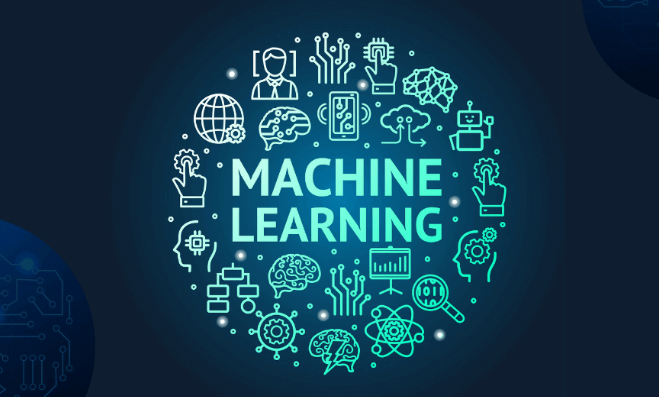

###Para esta segunda parte es necesario instalar estas bibliotecas sobre Machine Learning: Scikit-learn & Pycaret.

In [ ]:
!pip install scikit-learn
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 16.1 MB/s eta 0:00:00
   ━━━━━━

#PARTE 1

###Importo bibliotecas

In [ ]:
# Importo bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gspread
import pandas as pd
# Conexión a Google
from oauth2client.service_account import ServiceAccountCredentials
# Bibliotecas para predicciones
from sklearn.metrics import accuracy_score, classification_report

###Conexión a google

In [ ]:
# Me conecto a google y cargo credenciales
from google.colab import files
#En este caso por cuestiones de seguridad, cargo mis credenciales desde un archivo json, no es seguro dejarlo cargado en la notebook
uploaded = files.upload()

Saving census-401510-1c6d3f606ded.json to census-401510-1c6d3f606ded.json


In [ ]:
# Configuración del acceso a Google Sheets
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name("census-401510-1c6d3f606ded.json", scope)
client = gspread.authorize(creds)

In [ ]:
# Abrir la hoja de cálculo
spreadsheet = client.open("DDBB - Apioliga")

###Levanto dataset

In [ ]:
# Seleccionar las pestañas
goles_sheet = spreadsheet.worksheet("DDBB")
stats_sheet = spreadsheet.worksheet("STATS")

# Leer datos de Google Sheets en DataFrames
goles_df = pd.DataFrame(goles_sheet.get_all_records())
stats_df = pd.DataFrame(stats_sheet.get_all_records())

###Actualización de stats por partido

###Actualización de stats

In [ ]:
# Función para actualizar stats
def actualizar_stats(goles_df, stats_df):
    for partido in goles_df['Partido'].unique():
        partido_df = goles_df[goles_df['Partido'] == partido]
        equipo_ganador = partido_df[partido_df['Goles'] == partido_df['Goles'].max()]['Equipo'].iloc[0]

        # Actualizar stats para jugadores del equipo ganador
        for _, row in partido_df.iterrows():
            if row['Equipo'] == equipo_ganador:
                jugador = row['Jugador']
                if jugador in stats_df['NOMBRE'].values:
                    # Incrementar stats generales
                    stats_df.loc[stats_df['NOMBRE'] == jugador, ['RESISTENCIA', 'VELOCIDAD', 'DRIBLE', 'PEGADA', 'PASE', 'DEFENSA']] += 1
                    # Incrementar stats por goles
                    if row['Goles'] > 0:
                        stats_df.loc[stats_df['NOMBRE'] == jugador, ['RESISTENCIA', 'VELOCIDAD', 'DRIBLE', 'PEGADA', 'PASE', 'DEFENSA']] += 1

    # Actualizar la hoja de cálculo de stats
    stats_sheet.update([stats_df.columns.values.tolist()] + stats_df.values.tolist())

In [ ]:
# Ejecutar la actualización
actualizar_stats(goles_df, stats_df)

###Generación de equipos

In [ ]:
# Definir los equipos
equipo_1 = ['La Torre', 'Profe', 'Galgo', 'Smith Sr', 'Norber']
equipo_2 = ['Smith Sra', 'Chiche', 'Pantera', 'Massi', 'Mbappe']

### Predicción de resultados 101 - En base a estadisticas

In [ ]:
def obtener_estadisticas_equipo(equipo, stats_df):
    # Filtrar las estadísticas de los jugadores del equipo
    equipo_df = stats_df[stats_df['NOMBRE'].isin(equipo)]
    # Sumar las estadísticas de todos los jugadores del equipo
    stats_equipo = equipo_df[['RESISTENCIA', 'VELOCIDAD', 'DRIBLE', 'PEGADA', 'PASE', 'DEFENSA']].sum()
    return stats_equipo

def predecir_resultado(equipo_1, equipo_2, stats_df):
    # Obtener las estadísticas de ambos equipos
    stats_equipo_1 = obtener_estadisticas_equipo(equipo_1, stats_df)
    stats_equipo_2 = obtener_estadisticas_equipo(equipo_2, stats_df)

    # Comparar las estadísticas (ejemplo simple: sumar todas las estadísticas y comparar)
    puntaje_equipo_1 = stats_equipo_1.sum()
    puntaje_equipo_2 = stats_equipo_2.sum()

    if puntaje_equipo_1 > puntaje_equipo_2:
        return 'Equipo 1 gana'
    elif puntaje_equipo_1 < puntaje_equipo_2:
        return 'Equipo 2 gana'
    else:
        return 'Empate'

###Predecir resultados por stats

In [ ]:
# Predicciones de ejemplo
predicciones = predecir_resultado(equipo_1, equipo_2, stats_df)

###Evaluar precisión

In [ ]:
# Evaluar precisión
def obtener_resultado_real(partido_df):
    # Agrupar por equipo y sumar los goles
    resultado = partido_df.groupby('Equipo')['Goles'].sum()
    equipo_ganador = resultado.idxmax() if resultado.nunique() > 1 else 'Empate'
    return equipo_ganador

def evaluar_precision(goles_df, stats_df):
    resultados_reales = []
    resultados_predichos = []

    for partido in goles_df['Partido'].unique():
        # Obtener datos del partido
        partido_df = goles_df[goles_df['Partido'] == partido]

        # Obtener los equipos del partido
        equipos = partido_df['Equipo'].unique()
        equipo_1 = list(partido_df[partido_df['Equipo'] == equipos[0]]['Jugador'])
        equipo_2 = list(partido_df[partido_df['Equipo'] == equipos[1]]['Jugador'])

        # Resultado real
        resultado_real = obtener_resultado_real(partido_df)
        resultados_reales.append(resultado_real)

        # Predicción
        prediccion = predecir_resultado(equipo_1, equipo_2, stats_df)
        prediccion = equipos[0] if prediccion == 'Equipo 1 gana' else equipos[1] if prediccion == 'Equipo 2 gana' else 'Empate'
        resultados_predichos.append(prediccion)

    # Calcular precisión
    precision = accuracy_score(resultados_reales, resultados_predichos)
    reporte = classification_report(resultados_reales, resultados_predichos)

    return precision, reporte

###Resultados de la precisión

In [ ]:
# Evaluar la precisión
precision, reporte = evaluar_precision(goles_df, stats_df)
print(f"Precisión de las predicciones: {precision}")
print("Reporte de clasificación:")
print(reporte)

Precisión de las predicciones: 0.5833333333333334
Reporte de clasificación:
              precision    recall  f1-score   support

           A       0.60      1.00      0.75         6
      Empate       0.00      0.00      0.00         4
           R       0.50      0.50      0.50         2

    accuracy                           0.58        12
   macro avg       0.37      0.50      0.42        12
weighted avg       0.38      0.58      0.46        12



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##Accuracy (Precisión general): 0.58

Esto es como decir que el algoritmo acierta el 58% de las veces.
De cada 100 predicciones, acierta 58.

Precision (Precisión específica):

¿Qué tan a menudo tiene razón?
Por ejemplo, 0.60 para "A" significa que cuando predice "A", acierta el 60% de las veces.

Recall (Exhaustividad):

De todas las veces que realmente llovió, ¿cuántas veces lo predijo correctamente?
1.00 para "A" significa que cada vez que ocurrió "A", lo predijo correctamente

F1-score:

Es como una nota que combina precision y recall.

Support:

Es simplemente cuántas veces ocurrió cada tipo de clima en realidad.
Por ejemplo, "A" ocurrió 6 veces, "Empate" 4 veces, y "R" 2 veces.


Macro avg (Promedio macro):

Es como sacar un promedio simple de cómo le fue con cada tipo de clima.
No tiene en cuenta que algunos climas son más comunes que otros.


Weighted avg (Promedio ponderado):

Es parecido al promedio macro, pero da más importancia a los climas que ocurren más frecuentemente.
Es como si le diéramos más peso a las predicciones de los climas más comunes.

#PARTE 2

##Hasta ahora se trabajó con predicciones basadas en promedios pero ... ¿Porqué no es suficiente realizar predicciones basándose en ellos?

###Captura de Complejidad en los Datos

Los promedios representan únicamente una medida de tendencia central y no pueden capturar la complejidad de los datos ni las relaciones entre las variables independientes (features) y la variable objetivo.

Los modelos con train-test, en cambio, se entrenan con patrones específicos y relaciones complejas en los datos, permitiéndoles generar predicciones mucho más contextualizadas.

###Evaluación de Rendimiento y Ajuste del Modelo

Al usar un enfoque de train-test, podemos evaluar el rendimiento del modelo en datos no vistos (test) para obtener una medida objetiva de su capacidad predictiva. Esto permite detectar problemas como el overfitting o el underfitting y ajustar los parámetros del modelo para maximizar su precisión y generalización.

El promedio no es un modelo de predicción propiamente dicho, sino una medida estática.


En resumen, un enfoque de promedio no tiene capacidad de adaptación y tiende a ser impreciso cuando los datos cambian, pues asume que el pasado (promedio histórico) es un predictor confiable del futuro, lo cual rara vez es cierto en contextos complejos.

In [ ]:
#Nuevas bibliotecas para segunda parte de Machine Learning
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Exploro tipo de datos para luego pre-procesar

In [ ]:
print(stats_df.columns)
# En base a la función .info() identifico los datos numéricos y categóricos.
stats_df.info()

Index(['NOMBRE', 'POSICION', 'EDAD', 'RESISTENCIA', 'VELOCIDAD', 'DRIBLE',
       'PEGADA', 'PASE', 'DEFENSA', 'SEXO', 'MEDIA'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NOMBRE       25 non-null     object 
 1   POSICION     25 non-null     object 
 2   EDAD         25 non-null     int64  
 3   RESISTENCIA  25 non-null     int64  
 4   VELOCIDAD    25 non-null     int64  
 5   DRIBLE       25 non-null     int64  
 6   PEGADA       25 non-null     int64  
 7   PASE         25 non-null     int64  
 8   DEFENSA      25 non-null     int64  
 9   SEXO         25 non-null     object 
 10  MEDIA        25 non-null     float64
dtypes: float64(1), int64(7), object(3)
memory usage: 2.3+ KB




```
### Pre-processing - variables numéricas

In [ ]:
# Variables numéricas
numerical_columns = ['EDAD', 'RESISTENCIA', 'VELOCIDAD', 'DRIBLE', 'PEGADA', 'PASE', 'DEFENSA', 'MEDIA']

# Creo la instancia de Standarsclaler
scaler = StandardScaler()

# Procedo con la aplicación del StandarScaler
stats_df[numerical_columns] = scaler.fit_transform(stats_df[numerical_columns])

# Chequeo los resultados
print(stats_df[numerical_columns].describe())

               EDAD   RESISTENCIA     VELOCIDAD        DRIBLE        PEGADA  \
count  2.500000e+01  2.500000e+01  2.500000e+01  2.500000e+01  2.500000e+01   
mean  -3.830269e-16 -8.881784e-18 -2.664535e-17 -5.329071e-17  1.421085e-16   
std    1.020621e+00  1.020621e+00  1.020621e+00  1.020621e+00  1.020621e+00   
min   -2.418108e+00 -1.284595e+00 -1.253194e+00 -1.293339e+00 -1.314791e+00   
25%   -2.037234e-01 -7.076161e-01 -6.906416e-01 -7.052630e-01 -6.799899e-01   
50%    1.771508e-02 -1.850688e-01 -6.317899e-02 -1.278797e-01 -9.898587e-02   
75%    4.605920e-01  7.402753e-01  7.373768e-01  6.740416e-01  6.972048e-01   
max    2.010661e+00  2.656282e+00  2.652220e+00  2.726960e+00  2.719959e+00   

               PASE       DEFENSA         MEDIA  
count  2.500000e+01  2.500000e+01  2.500000e+01  
mean  -2.664535e-17 -2.664535e-17  1.421085e-16  
std    1.020621e+00  1.020621e+00  1.020621e+00  
min   -1.295755e+00 -1.377107e+00 -1.687308e+00  
25%   -6.719542e-01 -7.060020e-01 -9.8

### Pre-proccessing - variables categóricas

In [ ]:
# Crear una instancia de LabelEncoder
le = LabelEncoder()

# Preprocesamiento
# Aplicar LabelEncoder a cada columna categórica por separado
stats_df['SEXO'] = le.fit_transform(stats_df['SEXO'])

# Crear una nueva instancia de LabelEncoder para POSICION
le_posicion = LabelEncoder()
stats_df['POSICION'] = le_posicion.fit_transform(stats_df['POSICION'])

##Genero nuevos features para personalizar mi modelo de aprendizaje!

## Agrego LA MEDIA MÓVIL (Moving Average)
--------------------------------------------
La media móvil de los últimos 5 partidos es una técnica de análisis temporal que:
1. Calcula el promedio de goles considerando una ventana móvil de 5 partidos
2. Ayuda a identificar tendencias y suavizar fluctuaciones en el rendimiento
3. Es más representativa del rendimiento actual que la media total

Funcionamiento:
- Para cada jugador, ordena sus partidos por fecha
- Toma grupos de 5 partidos consecutivos
- Calcula la media de goles en cada grupo
- Se actualiza con cada nuevo partido

In [ ]:
# Crear características de rendimiento histórico y agregar la columna 'GOLES'
def create_historical_features(goles_df, stats_df):
    # Calcular la media de goles por jugador
    goles_promedio = goles_df.groupby('Jugador')['Goles'].mean().reset_index()
    goles_promedio.columns = ['NOMBRE', 'GOLES']

    # Unir con stats_df
    merged_df = stats_df.merge(goles_promedio, on='NOMBRE', how='left')

    # Calcular la media móvil de goles en los últimos 5 partidos
    if 'FECHA' in goles_df.columns:
        goles_df['FECHA'] = pd.to_datetime(goles_df['FECHA'])
        goles_df = goles_df.sort_values('FECHA')
        goles_df['GOLES_MA5'] = goles_df.groupby('Jugador')['Goles'].rolling(window=5, min_periods=1).mean().reset_index(0, drop=True)

        # Unir la media móvil con merged_df
        last_ma5 = goles_df.groupby('Jugador')['GOLES_MA5'].last().reset_index()
        merged_df = merged_df.merge(last_ma5, left_on='NOMBRE', right_on='Jugador', how='left')
        merged_df.drop('Jugador', axis=1, inplace=True)
    else:
        print("Advertencia: No se encontró la columna 'FECHA' en goles_df. No se calculará la media móvil.")

    # Imputar valores faltantes
    imputer = SimpleImputer(strategy='mean')
    for col in ['GOLES', 'GOLES_MA5']:
        if col in merged_df.columns:
            merged_df[col] = imputer.fit_transform(merged_df[[col]])

    return merged_df

## Agrego QUÍMICA ENTRE JUGADORES:
---------------------------------------
La química entre jugadores es un indicador sintético que:
1. Mide la compatibilidad potencial entre pares de jugadores
2. Combina habilidades complementarias (pase y drible)
3. Ayuda a predecir el rendimiento colectivo

Cálculo:
- Para cada par de jugadores (i,j):
  Química_{i,j} = (Pase_i + Drible_j) / 2

Interpretación:
- Valores altos indican mejor sinergia potencial
- Considera la capacidad de crear jugadas combinadas
- Ayuda a predecir el rendimiento del equipo como unidad

In [ ]:
# Crear características de química entre jugadores
def create_chemistry_features(df, equipo_1, equipo_2):
    for equipo in [equipo_1, equipo_2]:
        for i in range(len(equipo)):
            for j in range(i+1, len(equipo)):
                col_name = f'CHEMISTRY_{equipo[i]}_{equipo[j]}'
                df[col_name] = ((df[df['NOMBRE'] == equipo[i]]['PASE'].values[0] +
                                 df[df['NOMBRE'] == equipo[j]]['DRIBLE'].values[0]) / 2)
    return df


###A Partir de esta línea, el dataset principal pasa a ser el histórico

In [ ]:
# Preparar datos históricos
historical_data_df = create_historical_features(goles_df, stats_df)

###Exploro el dataset para chequear sus variables modificadas con el pre-procesamiento, además revisar las nuevas features, golesMA5

In [ ]:
# Visualizo la totalidad del dataframe
historical_data_df

,NOMBRE,POSICION,EDAD,RESISTENCIA,VELOCIDAD,DRIBLE,PEGADA,PASE,DEFENSA,SEXO,MEDIA,GOLES,GOLES_MA5
0,Chiche,0,0.239154,2.656282,2.652220,2.726960,2.719959,2.611210,2.627151,0,2.119091,3.333333,4.400000
1,Mbappe,6,0.239154,1.153959,1.148473,1.230040,1.192134,1.221337,1.083610,0,1.209459,3.000000,3.000000
2,Pantera,5,0.239154,1.578528,1.613661,1.550809,1.547192,1.582485,1.586939,0,1.178227,1.250000,2.200000
3,Profe,0,0.460592,1.360800,1.332384,1.283502,1.321246,1.385495,1.374422,0,1.080627,1.800000,0.600000
4,Chiqui,3,-0.203723,0.816480,0.748195,0.813041,0.783279,0.794526,0.837539,0,0.612147,1.666667,1.600000
5,Massi,1,2.010661,0.740275,0.780650,0.716811,0.751001,0.783582,0.960574,0,0.573107,1.125000,1.200000
6,La Torre,0,-2.418108,0.783821,0.737377,0.674042,0.697205,0.652255,0.636207,0,0.245171,1.200000,1.200000
7,Galgo,4,-1.753793,0.337478,0.369554,0.257043,0.213035,0.236388,0.233544,0,0.213939,0.250000,0.250000
8,Gonza,6,0.903469,-0.076205,-0.063179,0.160812,0.116201,0.126949,0.076953,1,0.174899,4.666667,4.666667
9,Tom,5,-0.425162,0.337478,0.250552,0.257043,0.213035,0.236388,0.233544,0,0.143667,1.400000,1.200000


###Genero nuevos equipos y cargo nueva feaure, química entre jugadores que juegan próximo partido

In [ ]:
# Definir los equipos
equipo_1 = ['Chiqui', 'Profe', 'Pantera', 'Smith Sra', 'Massi']
equipo_2 = ['Smith Sr', 'Tom', 'Espartana', 'Bandida', 'Mbappe']

### Ejecuto la función de crear química entre jugadores, basado en los equipos conformados en la línea anterior

In [ ]:
# Crear características de química
historical_data_df = create_chemistry_features(historical_data_df, equipo_1, equipo_2)

## Defino features ! :) Paso fundamental para el machine learning definir las variables independientes o features.

In [ ]:
# Definir características y variable objetivo
features = ['RESISTENCIA', 'VELOCIDAD', 'DRIBLE', 'PEGADA', 'PASE', 'DEFENSA', 'SEXO', 'GOLES_MA5'] + [col for col in historical_data_df.columns if col.startswith('CHEMISTRY_')]

## Divido en dos variables, features y targets

In [ ]:
X = historical_data_df[features]
y = historical_data_df['GOLES']

##Spliteo y entreno el modelo, se pueden usar diferentes opciones para calcular la cantidad de goles que se pueden realizar. Arbol de decisiones es interesante porque:
###Es robusto frente a outliers y ruido en los datos
###Maneja bien relaciones no lineales entre variables
###Puede capturar interacciones complejas entre características
###Proporciona medidas de importancia de variables
###Dejo comentadas en el código otras opciones

In [ ]:
def train_model(historical_data_df, features, test_size=0.2):
    # Dividir los datos en entrenamiento y prueba
    X = historical_data_df[features]
    y = historical_data_df['GOLES']

    # Eliminar filas con NaN en la variable objetivo
    X = X[~y.isna()]
    y = y[~y.isna()]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    # Escalar características
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Entrenar modelo
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )

    model.fit(X_train_scaled, y_train)

    # Evaluar modelo
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)

    print(f"R² Score (Train): {train_score:.3f}")
    print(f"R² Score (Test): {test_score:.3f}")

    return model, scaler, train_score, test_score

    '''

1 Modelo de regresión de Poisson (PoissonRegressor):
Este modelo es especialmente útil para datos de conteo, como goles.
La regresión de Poisson asume que la variable dependiente sigue una distribución de Poisson, común en eventos de conteo.

#CÓDIGO
from sklearn.linear_model import PoissonRegressor

model = PoissonRegressor(alpha=1.0)
model.fit(X_train_scaled, y_train)


2 Gradient Boosting Regressor (GradientBoostingRegressor):
El GradientBoostingRegressor es otra opción sólida, ya que crea un modelo mediante el ensamble de varios árboles de decisión.
Tiende a ofrecer un alto rendimiento en datos con relaciones no lineales y permite un ajuste más fino de hiperparámetros, como la tasa de aprendizaje, que ayuda a evitar el sobreajuste.

#CÓDIGO
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
model.fit(X_train_scaled, y_train)

3 XGBoost Regressor:
XGBoost es otra técnica de ensamble popular para datos con patrones complejos y suele superar a Random Forest en rendimiento y velocidad de entrenamiento.
XGBoost también tiene parámetros avanzados que ayudan a ajustar el modelo y prevenir el sobreajuste, y en muchos casos, es capaz de lograr predicciones precisas para variables
 de conteo como goles.

#CÓDIGO
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train_scaled, y_train)

'''

###Creo y entreno el modelo:

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

###Aplico la función y obtengo los resultados!

In [ ]:
model, scaler, train_score, test_score = train_model(historical_data_df, features)


R² Score (Train): 0.785
R² Score (Test): 0.451


### El R2 es de 0.755 en el train y 0.451 en el test. Esto significa que... :


Coeficiente de determinación indica qué tan bien un modelo explica la variabilidad de los datos de salida (por ejemplo, la cantidad de goles en este caso). Un valor de
𝑅
2
R
2
  más cercano a 1 significa que el modelo hace buenas predicciones, mientras que un valor cercano a 0 indica que predice mal. Si un modelo tiene un
𝑅
2
R
2
  de 0.8, significa que puede explicar el 80% de los goles que hace el jugador, mientras que el 20% restante no se puede predecir bien.

###Interpretación:
Nuestro modelo tiene una diferencia muy grande entre los resultados de entrenamiento y de test porque está sobre ajustado! (Overfit). Una alternativa de solución sería una técnica de Cross_val_score

###Cross_val_score:

####La función cross_val_score toma el modelo y los datos (X y y) y los divide en k grupos o "folds" (en este caso, 5 por el parámetro cv=5). Cada vez, entrena el modelo con 4 de estos folds y lo evalúa en el fold restante, repitiendo este proceso cinco veces (una por cada fold). Esto permite obtener una métrica de *error* para cada división, lo cual reduce la posibilidad de sesgo en la evaluación.

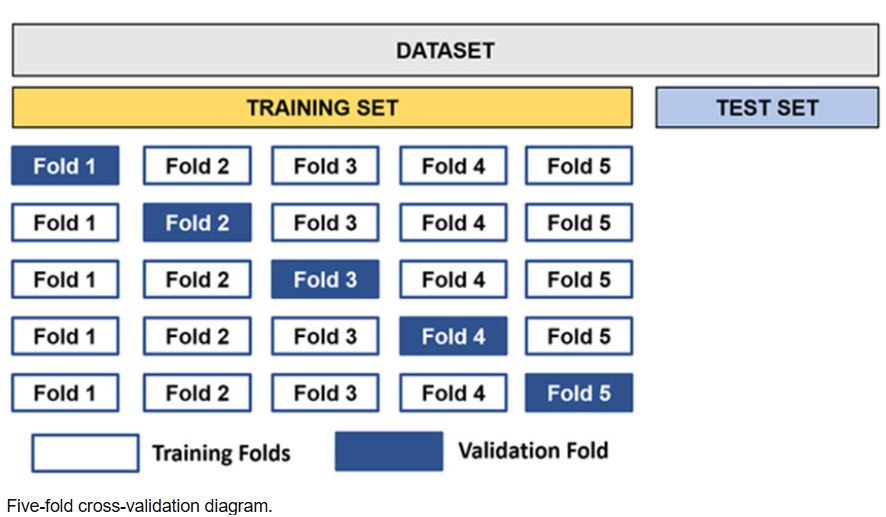

In [ ]:
#Nuevas bibliotecas para el cross_val_score
from sklearn.model_selection import cross_val_score
import numpy as np

def train_model_with_cross_val(historical_data_df, features, cv=5):
    # Dividir los datos en características y objetivo
    X = historical_data_df[features]
    y = historical_data_df['GOLES']

    # Eliminar filas con NaN en la variable objetivo
    X = X[~y.isna()]
    y = y[~y.isna()]

    # Escalar características
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Entrenar modelo
    model = RandomForestRegressor(
        n_estimators=50,
        max_depth=5,  # Limitar profundidad para evitar overfitting
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )

    # Evaluar el modelo usando validación cruzada
    scores = cross_val_score(model, X_scaled, y, cv=6, scoring='r2')

    print(f"R² Scores (Cross-Validation): {scores}")
    print(f"Promedio R² Score: {np.mean(scores):.3f}")

    # Entrenar el modelo en todo el conjunto de datos
    model.fit(X_scaled, y)

    return model, scaler, scores

# Uso de la función
model, scaler, cross_val_scores = train_model_with_cross_val(historical_data_df, features)

R² Scores (Cross-Validation): [-0.50859797  0.51786917  0.7344336   0.86122155  0.92011447  0.        ]
Promedio R² Score: 0.421


###Ultimo esfuerzo! vamos a hacer un ajuste para que nos dé los mejores parámetros para obtener los mejores resultados

In [ ]:
from sklearn.model_selection import GridSearchCV

def train_model_with_grid_search(historical_data_df, features):
    # Dividir los datos en características y objetivo
    X = historical_data_df[features]
    y = historical_data_df['GOLES']

    # Eliminar filas con NaN en la variable objetivo
    X = X[~y.isna()]
    y = y[~y.isna()]

    # Escalar características
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Definir el modelo
    model = RandomForestRegressor(random_state=42)

    # Definir el espacio de búsqueda de hiperparámetros
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Configurar la búsqueda en cuadrícula
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

    # Ejecutar la búsqueda
    grid_search.fit(X_scaled, y)

    print(f"Mejores parámetros: {grid_search.best_params_}")
    print(f"Mejor R² Score: {grid_search.best_score_:.3f}")

    # Entrenar el modelo final con los mejores parámetros
    best_model = grid_search.best_estimator_
    best_model.fit(X_scaled, y)

    return best_model, scaler

# Uso de la función
best_model, scaler = train_model_with_grid_search(historical_data_df, features)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor R² Score: 0.441


##Interpretación final

Si bien el promedio puede mostrar inicialmente una mayor precisión, esta medida es estática y no puede capturar cambios en la estructura de los datos a lo largo del tiempo. Esto significa que, a medida que los datos evolucionan, el promedio probablemente perderá precisión, mientras que un modelo entrenado con un enfoque de train-test puede ajustarse y mejorar con el tiempo.

Aunque en ciertos momentos el promedio pueda superar la precisión de un modelo entrenado, esta ventaja es generalmente coyuntural y no sostenible a largo plazo. El enfoque de train-test proporciona una base más sólida para lograr predicciones robustas, sostenibles y adaptables a nuevas condiciones, superando la limitación del promedio de ofrecer un único valor que no refleja la verdadera complejidad de los datos.

#BONUS TRACK - UNA INTRO A PYCARET 🙂

**IMPLEMENTACIÓN** DE PYCARET PARA ANÁLISIS PREDICTIVO
------------------------------------------------
PyCaret es una biblioteca de AutoML que automatiza el proceso de aprendizaje automático:
1. Simplifica el preprocesamiento de datos
2. Permite comparar múltiples modelos rápidamente
3. Facilita la optimización de hiperparámetros
4. Proporciona herramientas de evaluación integradas

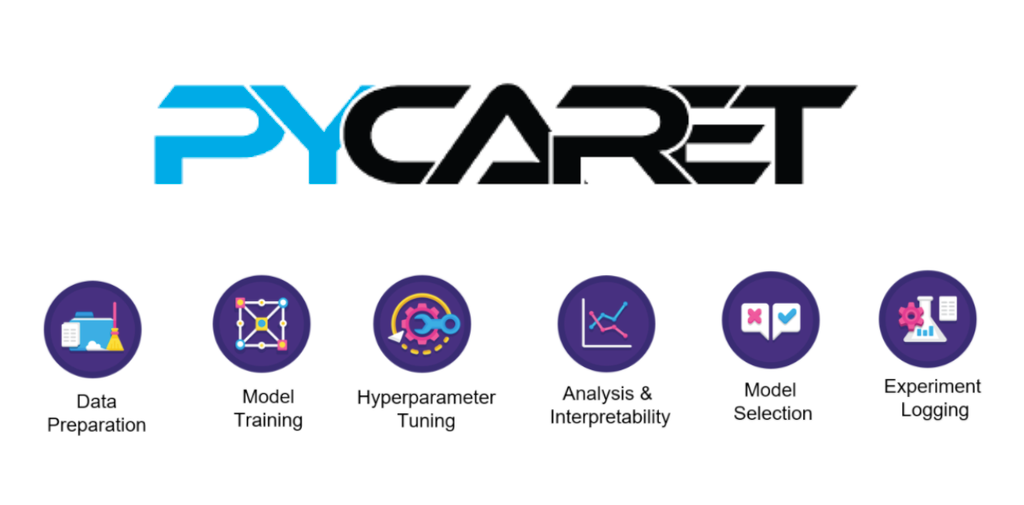

## Import bibliotecas para Pycaret

In [ ]:
# Bibliotecas para Pycaret
import pycaret
from pycaret.classification import *

In [ ]:
# Preparar los datos para el modelo
# Primero creamos variable objetivo (target) basada en si el jugador marcó gol
# Usar historical_data_df en lugar de df
historical_data_df['marco_gol'] = (historical_data_df['GOLES'] > 0).astype(int)

PREPARACIÓN DEL ENTORNO DE MODELADO
---------------------------------
La función setup() de PyCaret:
1. Preprocesa automáticamente los datos
2. Maneja valores faltantes
3. Codifica variables categóricas
4. Escala características numéricas

In [ ]:
# Reemplazar espacios por guiones bajos en los nombres de columnas
historical_data_df.columns = historical_data_df.columns.str.replace(' ', '_')

# Configurar PyCaret
clf = setup(
    data=historical_data_df,
    target='marco_gol',
    session_id=123,
    feature_selection=True,
    normalize=True,
    ignore_features=['NOMBRE']
)


COMPARACIÓN DE MODELOS
--------------------
compare_models():
1. Entrena y evalúa múltiples modelos
2. Compara métricas de rendimiento
3. Identifica el mejor modelo automáticamente

Métricas evaluadas:
- Accuracy
- AUC
- Recall
- Precision
- F1 Score

In [ ]:
# Comparación de modelos
print("Comparando modelos de clasificación...")
best_model = compare_models(
    n_select=3,           # Seleccionar top 3 modelos
    sort='Accuracy'       # Ordenar por precisión
)

Comparando modelos de clasificación...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9500,0.2000,1.0000,0.9500,0.9667,nan,0.1000,0.3480
lda,Linear Discriminant Analysis,0.9500,0.2000,1.0000,0.9500,0.9667,nan,0.1000,0.0620
knn,K Neighbors Classifier,0.9000,0.1500,1.0000,0.9000,0.9333,nan,0.0000,0.0850
dt,Decision Tree Classifier,0.9000,0.1000,0.9000,0.9000,0.9000,nan,0.0000,0.0800
svm,SVM - Linear Kernel,0.9000,0.2000,0.9500,0.9500,0.9333,nan,0.1000,0.0830
ridge,Ridge Classifier,0.9000,0.1000,1.0000,0.9000,0.9333,nan,0.0000,0.1010
rf,Random Forest Classifier,0.9000,0.1000,1.0000,0.9000,0.9333,nan,0.0000,0.4540
ada,Ada Boost Classifier,0.9000,0.1000,0.9000,0.9000,0.9000,nan,0.0000,0.1520
gbc,Gradient Boosting Classifier,0.9000,0.1000,0.9000,0.9000,0.9000,nan,0.0000,0.1320
et,Extra Trees Classifier,0.9000,0.1000,1.0000,0.9000,0.9333,nan,0.0000,0.2090


Processing:   0%|          | 0/67 [00:00<?, ?it/s]

CREACIÓN Y EVALUACIÓN DE MODELO ESPECÍFICO
----------------------------------------
create_model():
- Crea una instancia de un modelo específico
- Aplica validación cruzada automática
- Genera métricas de rendimiento detalladas

In [ ]:
# Creo el modelo!
print("\nCreando y evaluando modelo de regresión logística...")
logistic_model = create_model('lr')


Creando y evaluando modelo de regresión logística...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,nan,0.0000
1,1.0000,0.0000,1.0000,1.0000,1.0000,nan,0.0000
2,1.0000,0.0000,1.0000,1.0000,1.0000,nan,0.0000
3,1.0000,0.0000,1.0000,1.0000,1.0000,nan,0.0000
4,1.0000,0.0000,1.0000,1.0000,1.0000,nan,0.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.5000,1.0000,1.0000,0.5000,0.6667,0.0000,0.0000
7,1.0000,0.0000,1.0000,1.0000,1.0000,nan,0.0000
8,1.0000,0.0000,1.0000,1.0000,1.0000,nan,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Evaluación detallada del modelo
print("\nEvaluación detallada del modelo:")
evaluate_model(logistic_model)


Evaluación detallada del modelo:


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

AFINAMIENTO DEL MODELO
--------------------
tune_model():
1. Realiza búsqueda de hiperparámetros
2. Utiliza validación cruzada
3. Optimiza el rendimiento del modelo

Proceso:
- Prueba diferentes combinaciones de parámetros
- Selecciona la mejor configuración
- Retorna el modelo optimizado

In [ ]:
# Afinando el modelo...
tuned_logistic_model = tune_model(
    logistic_model,
    n_iter=50,            # Número de iteraciones
    optimize='Accuracy'    # Métrica a optimizar
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,nan,0.0000
1,1.0000,0.0000,1.0000,1.0000,1.0000,nan,0.0000
2,1.0000,0.0000,1.0000,1.0000,1.0000,nan,0.0000
3,1.0000,0.0000,1.0000,1.0000,1.0000,nan,0.0000
4,1.0000,0.0000,1.0000,1.0000,1.0000,nan,0.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.5000,0.0000,1.0000,0.5000,0.6667,0.0000,0.0000
7,1.0000,0.0000,1.0000,1.0000,1.0000,nan,0.0000
8,1.0000,0.0000,1.0000,1.0000,1.0000,nan,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


PREDICCIONES Y ANÁLISIS FINAL


In [ ]:
# Realizar predicciones con el modelo afinado
predictions = predict_model(tuned_logistic_model)

# Guardar el modelo para uso futuro
save_model(tuned_logistic_model, 'modelo_futbol_optimizado')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8750,0.7143,1.0000,0.8750,0.9333,0.0000,0.0000


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['POSICION', 'EDAD', 'RESISTENCIA',
                                              'VELOCIDAD', 'DRIBLE', 'PEGADA',
                                              'PASE', 'DEFENSA', 'SEXO', 'MEDIA',
                                              'GOLES', 'GOLES_MA5',
                                              'CHEMISTRY_Chiqui_Profe',
                                              'CHEMISTRY_Chiqui_Pantera',
                                              'CHEMISTRY_Chiqui_Smith_Sra',
                                              'CHEMISTRY_Chiqui_Massi',
                                              'CHEMISTRY_Profe_Panter...
                                                                 importance_getter='auto',
                                                                 max_features=6,
                     